In [1]:
import pandas as pd

df = pd.read_csv("/media/souravsaini/Data/POP_OS/internship/eRisk/dataset/train_data.csv")
df = df.dropna().reset_index(drop=True)

In [2]:
df.head()

,Unnamed: 0,subject_ID,text,Anorexia
0,0,1074,[pc] [h] 4 keys maybe 5? [w] endo so why d...,0
1,1,1101,Because he saw a movie once? It's Cana...,0
2,2,1120,What book should I read next that will scare ...,0
3,3,1137,''I only drink soda at parties'' Are y...,0
4,4,1143,"Once I named myself 'pros solo', the numbe...",0


In [3]:
import re

def remove_urls(text):
    # Define the pattern to match URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')

    # Replace URLs with an empty string
    text_without_urls = url_pattern.sub('', text)
    text_wihtout_urls = ''.join(filter(lambda x: x.isalpha() or x.isdigit() or x.isspace(), text_without_urls))
    return text_without_urls

In [4]:
from transformers import LongformerTokenizer, LongformerForSequenceClassification

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096", strip_accents=True, remove_punctuations=True)

tokenized_text = tokenizer.tokenize(remove_urls(df['text'][0]))

/media/souravsaini/Data/POP_OS/internship/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
def split_text_into_subtexts(text, max_length):
    subtexts = []
    words = text.split()
    current_subtext = ''
    for word in words:
        if len(current_subtext) + len(word) < max_length:
            current_subtext += ' ' + word
        else:
            subtexts.append(current_subtext.strip())
            current_subtext = word
    if current_subtext:
        subtexts.append(current_subtext.strip())
    return subtexts

In [6]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import LongformerTokenizer, LongformerModel
from tqdm import tqdm

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096", 
                                                cache_dir="/media/souravsaini/Data/POP_OS/internship/env/model_weigths")
model = LongformerModel.from_pretrained("allenai/longformer-base-4096",
                                        cache_dir="/media/souravsaini/Data/POP_OS/internship/env/model_weigths")
Device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(Device)
for index, row in tqdm(df.iterrows()):
    text = row['text']
    target = row['Anorexia']

    subtexts = split_text_into_subtexts(text, 4000)

    temp = []
    model.eval()
    for sub in subtexts:
        inputs = tokenizer(sub, return_tensors="pt", truncation=True, padding=True)
        inputs = {key: value.to(Device) for key, value in inputs.items()}
        with torch.no_grad():
            output = model(**inputs)
        temp.append(output.last_hidden_state.squeeze().cpu())
    final_logits = torch.cat(temp, dim=0)
    if target==0:
        np.save(f"/media/souravsaini/Data/POP_OS/internship/eRisk/dataset/negative/{index}.npy",
                final_logits.cpu().numpy())
    else:
        np.save(f"/media/souravsaini/Data/POP_OS/internship/eRisk/dataset/{index}.npy",
                final_logits.cpu().numpy())

0it [00:00, ?it/s]Input ids are automatically padded from 1063 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1077 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1050 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1057 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1088 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1027 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1117 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1033 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1047 to 1536 to be a multiple of `config.attention_window`: 512
Input ids are automatically padded from 1107 t

In [7]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

Device = "cuda" if torch.cuda.is_available() else "cpu"
# Device = "cpu"

class CustomDataset(Dataset):
    def __init__(self, data_folder, is_positive):
        self.data_folder = data_folder
        self.label = 1 if is_positive else 0
        self.data = []

        # Load data from numpy files
        for file_name in os.listdir(data_folder):
            if file_name.endswith('.npy'):
                file_path = os.path.join(data_folder, file_name)
                self.data.append(file_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # return torch.from_numpy(np.load(self.data[idx])), torch.ones(1,1) * self.label
        return self.data[idx], self.label

# Paths to the folders containing numpy arrays
positive_folder = "/media/souravsaini/Data/POP_OS/internship/eRisk/dataset/positive"
negative_folder = "/media/souravsaini/Data/POP_OS/internship/eRisk/dataset/negative"

# Create datasets for positive and negative classes
positive_dataset = CustomDataset(positive_folder, is_positive=True)
negative_dataset = CustomDataset(negative_folder, is_positive=False)

# Split datasets into training and validation sets
train_positive, val_positive = train_test_split(positive_dataset, test_size=0.4, random_state=42)
train_negative, val_negative = train_test_split(negative_dataset, test_size=0.2, random_state=42)

# Concatenate positive and negative training datasets
train_dataset = torch.utils.data.ConcatDataset([train_positive, train_negative])

# Concatenate positive and negative validation datasets
val_dataset = torch.utils.data.ConcatDataset([val_positive, val_negative])

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # self.attention = nn.MultiheadAttention(768, 8)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = x.unsqueeze(0)
        # x, _ = self.attention(x, x, x)
        # x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [4]:
Device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
# Initialize the model and optimizer
num_labels = 1
model = BinaryClassifier()
model.to(Device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
num_epochs = 50

/home/ajeet/Sourav/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
for x, y in train_dataset:
    x = torch.from_numpy(np.load(x)).to(Device)
    y = torch.ones(1,1).to(Device) * y
    print(x.shape, y.shape)
    logits = model(x)
    print(logits.shape)
    break

torch.Size([12970, 768]) torch.Size([1, 1])
torch.Size([1, 1])


In [11]:
import os
from tqdm import tqdm

best_val_loss = 1e+6

for epoch in range(num_epochs):
    model.train()
    loss_train = 0
    for feature, labels in tqdm(train_dataset, desc=f"training epoch = {epoch}"): 
        optimizer.zero_grad()
        feature = torch.from_numpy(np.load(feature))
        labels = torch.ones(1,1).to(Device) * labels
        # if feature.shape[0]>10000:
        #     partition = int((feature.shape[0])/2)

        #     ft = feature[:partition]
        #     logits = model(ft.to(Device))
        #     loss1 = criterion(logits, labels.float())

        #     ft = ft.cpu()
        #     ft = feature[partition:]
        #     logits = model(ft.to(Device))
        #     loss2 = criterion(logits, labels.float())

        #     loss_train += (loss1.item() + loss2.item())/2
        #     loss = (loss1 + loss2)/2
        #     loss.backward()

        # else:            
        feature = feature.to(Device)
        logits = model(feature)
        loss = criterion(logits, labels.float())
        loss_train += loss.item()
        loss.backward()
        optimizer.step()

    print(f"training_loss = {loss_train/len(train_dataset)}")

    # Validation loop
    model.eval()
    val_loss = 0
    num_val_steps =  0
    with torch.no_grad():
        for feature, labels in tqdm(val_dataset, desc=f"validation epoch = {epoch}"):
            labels = torch.ones(1,1).to(Device) * labels
            feature = torch.from_numpy(np.load(feature))
            # if feature.shape[0]>10000:
            #     partition = int((feature.shape[0])/2)

            #     ft = feature[:partition]
            #     logits = model(ft.to(Device))
            #     loss1 = criterion(logits, labels.float())

            #     ft = ft.cpu()
            #     ft = feature[partition:]
            #     logits = model(ft.to(Device))
            #     loss2 = criterion(logits, labels.float())

            #     val_loss += (loss1.item() + loss2.item())/2
            #     loss = (loss1 + loss2)/2

            # else:            
            feature = feature.to(Device)
            logits = model(feature)
            loss = criterion(logits, labels.float())
            val_loss += loss.item()

            num_val_steps += 1

    val_loss /= num_val_steps

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(),
               os.path.join("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/att",
                            f"model_best.pt"))

    if epoch%5 == 0:
        torch.save(model.state_dict(),
               os.path.join("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/att",
                            f"epoch_{epoch}_val_loss_{val_loss}.pt"))

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Val loss: {val_loss:.4f}')

training epoch = 0:  10%|█         | 181/1809 [04:24<39:35,  1.46s/it]  


KeyboardInterrupt: 

In [25]:
probs, target = [], []
model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/epoch_45_val_loss_1.516101801927047.pt"))
model.eval()
with torch.no_grad():
    for feature, labels in tqdm(val_dataset, desc=f"validation epoch = {epoch}"):
        feature = torch.from_numpy(np.load(feature))
        if feature.shape[0]>10000:
            partition = int((feature.shape[0])/2)

            ft = feature[:partition]
            logits = model(ft.to(Device))

            ft = ft.cpu()
            ft = feature[partition:]
            logits += model(ft.to(Device))
            logits /= 2

        else:            
            feature = feature.to(Device)
            logits = model(feature)

        probs.append(logits[0][0])
        target.append(labels)

validation epoch = 49: 100%|██████████| 522/522 [03:30<00:00,  2.48it/s]


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

def threshold_prediction(probabilities, threshold):
    predictions = []
    for prob in probabilities:
        if prob > threshold: predictions.append(1)
        else: predictions.append(0)
    return predictions

def calculate_precision_recall(probabilities, labels, thresholds):
    results = []
    for threshold in thresholds:
        predictions = threshold_prediction(probabilities, threshold)
        precision = precision_score(labels, predictions)
        recall = recall_score(labels, predictions)
        results.append({'Threshold': threshold, 'Precision': precision, 'Recall': recall})
    return pd.DataFrame(results)

## results from last epoch model's weight

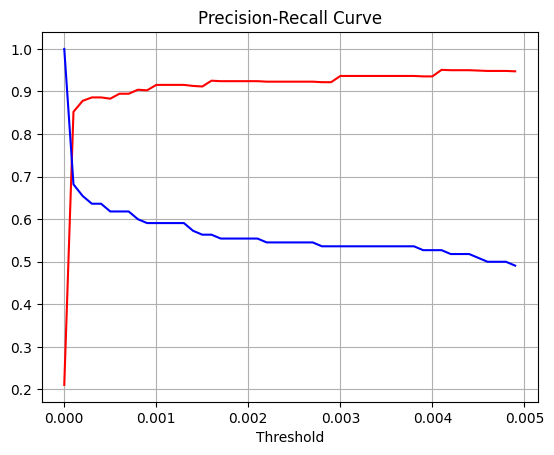

    Threshold  Precision    Recall
0      0.0000   0.210728  1.000000
1      0.0001   0.852273  0.681818
2      0.0002   0.878049  0.654545
3      0.0003   0.886076  0.636364
4      0.0004   0.886076  0.636364
5      0.0005   0.883117  0.618182
6      0.0006   0.894737  0.618182
7      0.0007   0.894737  0.618182
8      0.0008   0.904110  0.600000
9      0.0009   0.902778  0.590909
10     0.0010   0.915493  0.590909
11     0.0011   0.915493  0.590909
12     0.0012   0.915493  0.590909
13     0.0013   0.915493  0.590909
14     0.0014   0.913043  0.572727
15     0.0015   0.911765  0.563636
16     0.0016   0.925373  0.563636
17     0.0017   0.924242  0.554545
18     0.0018   0.924242  0.554545
19     0.0019   0.924242  0.554545
20     0.0020   0.924242  0.554545
21     0.0021   0.924242  0.554545
22     0.0022   0.923077  0.545455
23     0.0023   0.923077  0.545455
24     0.0024   0.923077  0.545455
25     0.0025   0.923077  0.545455
26     0.0026   0.923077  0.545455
27     0.0027   0.92

In [27]:
thresholds = np.arange(0, 0.005, 0.0001)
results_df = calculate_precision_recall(probs, target, thresholds)

plt.plot(thresholds, results_df['Precision'], color="red")
plt.plot(thresholds, results_df['Recall'], color="blue")
plt.xlabel('Threshold')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

print(results_df)

In [16]:
probs, target = [], []
model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/epoch_20_val_loss_1.2015374532240015.pt"))
model.to(Device)
model.eval()
with torch.no_grad():
    for feature, labels in tqdm(val_dataset, desc=f"validation epoch = {epoch}"):
        feature = torch.from_numpy(np.load(feature))
        if feature.shape[0]>10000:
            partition = int((feature.shape[0])/2)

            ft = feature[:partition]
            logits = model(ft.to(Device))

            ft = ft.cpu()
            ft = feature[partition:]
            logits += model(ft.to(Device))
            logits /= 2

        else:            
            feature = feature.to(Device)
            logits = model(feature)

        probs.append(logits[0][0].cpu())
        target.append(labels)

validation epoch = 49: 100%|██████████| 522/522 [03:27<00:00,  2.51it/s]


## result from best validation loss model's weight

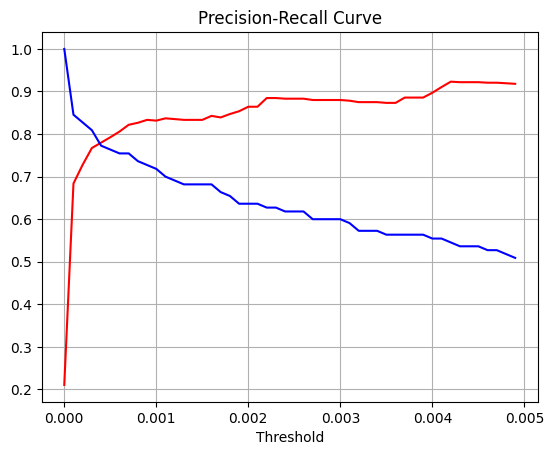

    Threshold  Precision    Recall
0      0.0000   0.210728  1.000000
1      0.0001   0.683824  0.845455
2      0.0002   0.728000  0.827273
3      0.0003   0.767241  0.809091
4      0.0004   0.779817  0.772727
5      0.0005   0.792453  0.763636
6      0.0006   0.805825  0.754545
7      0.0007   0.821782  0.754545
8      0.0008   0.826531  0.736364
9      0.0009   0.833333  0.727273
10     0.0010   0.831579  0.718182
11     0.0011   0.836957  0.700000
12     0.0012   0.835165  0.690909
13     0.0013   0.833333  0.681818
14     0.0014   0.833333  0.681818
15     0.0015   0.833333  0.681818
16     0.0016   0.842697  0.681818
17     0.0017   0.839080  0.663636
18     0.0018   0.847059  0.654545
19     0.0019   0.853659  0.636364
20     0.0020   0.864198  0.636364
21     0.0021   0.864198  0.636364
22     0.0022   0.884615  0.627273
23     0.0023   0.884615  0.627273
24     0.0024   0.883117  0.618182
25     0.0025   0.883117  0.618182
26     0.0026   0.883117  0.618182
27     0.0027   0.88

In [23]:
thresholds = np.arange(0, 0.005, 0.0001)
results_df = calculate_precision_recall(probs, target, thresholds)

plt.plot(thresholds, results_df['Precision'], color="red")
plt.plot(thresholds, results_df['Recall'], color="blue")
plt.xlabel('Threshold')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

print(results_df)

In [24]:
results_df.to_csv("/media/souravsaini/Data/POP_OS/internship/eRisk/threshold_vs_precision_recall_longformer.csv")

In [3]:
import torch
import torch.nn as nn

# Assuming you have your input tensor stored in 'input_tensor'
# input_tensor shape: (x, 765)

# Reshape input tensor to (seq_len, batch_size, embed_dim) format
input_tensor = torch.rand((20, 768))
# input_tensor = input_tensor.transpose(0, 1)  # Shape: (765, x)

# Define the multi-head self-attention layer
# You need to specify the embedding dimension and the number of attention heads
embed_dim = 768
num_heads = 8  # You can adjust this number as needed
attention_layer = nn.MultiheadAttention(embed_dim, num_heads)

# Apply self-attention
# Make sure to pass the input tensor twice because it's a self-attention mechanism
output_tensor, _ = attention_layer(input_tensor, input_tensor, input_tensor)

# Reshape the output tensor back to its original shape
output_tensor = output_tensor.transpose(0, 1)  # Shape: (x, 765)

print(output_tensor.shape)


torch.Size([768, 20])


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)
        self.softmax = nn.Softmax(dim=2)
        
    def forward(self, x):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / (self.input_dim ** 0.5)
        # attention = self.softmax(scores)
        weighted = torch.bmm(scores, values)
        return weighted

In [6]:
att = SelfAttention(768)

out = att(input_tensor.unsqueeze(0))
out.shape

torch.Size([1, 20, 768])

# Testing

In [1]:
import pandas as pd

testing_dataset = pd.read_csv("/home/ajeet/Sourav/test_data.csv")
testing_dataset.head()

,Unnamed: 0,subject_ID,num_writings,text,Anorexia
0,0,1152_1,4,Student at uw. Need a few hours away from cam...,1
1,1,1169_1,14,"Haha, nailed it dude.\n Rings are defi...",1
2,2,1441_1,55,"Right, which is why I said those people wo...",1
3,3,1518_1,31,I just have a lot of self hatred and depri...,1
4,4,1773_1,1,Thank you for your long reply! I have been...,1


In [5]:
delay_dict = dict(zip(testing_dataset['subject_ID'], testing_dataset['num_writings']))

In [8]:
import os
import pandas as pd
import torch
import numpy as np
from transformers import LongformerTokenizer, LongformerModel
from tqdm import tqdm

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096", 
                                                cache_dir="/home/ajeet/Sourav/pre_trained_weigths")
model = LongformerModel.from_pretrained("allenai/longformer-base-4096",
                                        cache_dir="/home/ajeet/Sourav/pre_trained_weigths")
Device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(Device)

base_path = "/home/ajeet/Sourav/test_dataset_longformer_without_aug"

testing_dataset['text'] = testing_dataset['text'].astype(str)

for index, row in tqdm(testing_dataset.iterrows()):
    text = row['text']
    target = row['Anorexia']

    subtexts = split_text_into_subtexts(text, 4000)

    try:
        temp = []
        model.eval()
        for sub in subtexts:
            inputs = tokenizer(sub, return_tensors="pt", truncation=True, padding=True)
            inputs = {key: value.to(Device) for key, value in inputs.items()}
            with torch.no_grad():
                output = model(**inputs)
            temp.append(output.last_hidden_state.squeeze().cpu())
        final_logits = torch.cat(temp, dim=0)
        chunk = row["subject_ID"].split("_")[-1]
        subject_id = int(row["subject_ID"].split("_")[0])
        if not os.path.exists(os.path.join(base_path, chunk)):
            try: os.mkdir(os.path.join(base_path, chunk))
            except: pass
        np.save(os.path.join(base_path, chunk, f'{subject_id}.npy'),
                    final_logits.cpu().numpy())
        # print("done\n")
    except:
        print("fail\n")

0it [00:00, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Input ids are automatically padded to be a multiple of `config.attention_window`: 512
2it [00:00,  3.00it/s]

done

done



4it [00:01,  3.93it/s]

done

done

done



7it [00:02,  3.15it/s]

done

done

done



10it [00:02,  5.89it/s]

done

done

done



12it [00:02,  6.31it/s]

done



15it [00:03,  4.47it/s]

done

done

done



19it [00:04,  6.95it/s]

done

done

done

done

done



21it [00:05,  4.29it/s]

done



22it [00:05,  4.22it/s]

done



23it [00:05,  4.16it/s]

done



24it [00:05,  3.78it/s]

done

done

done



30it [00:06,  7.50it/s]

done

done

done

done

done



34it [00:06,  8.78it/s]

done

done

done

done

done



38it [00:07,  7.32it/s]

done

done



40it [00:07,  8.47it/s]

done

done



42it [00:07,  8.52it/s]

done

done



43it [00:08,  7.26it/s]

done

done



45it [00:08,  6.75it/s]

done



46it [00:09,  4.13it/s]

done

done



48it [00:09,  4.34it/s]

done

done

done



51it [00:09,  4.94it/s]

done



53it [00:10,  4.75it/s]

done

done



57it [00:10,  7.50it/s]

done

done

done

done

done

done



62it [00:11,  9.62it/s]

done

done

done

done



64it [00:11, 10.59it/s]

done

done



66it [00:11,  9.92it/s]

done



68it [00:12,  5.06it/s]

done

done

done



70it [00:12,  5.94it/s]

done



72it [00:13,  3.41it/s]

done

done



73it [00:14,  3.94it/s]

done



76it [00:14,  5.75it/s]

done

done

done



80it [00:15,  6.73it/s]

done

done

done

done

done



82it [00:15,  7.01it/s]

done



84it [00:15,  7.11it/s]

done

done



86it [00:16,  5.86it/s]

done

done



88it [00:16,  6.21it/s]

done

done



89it [00:16,  5.23it/s]

done

done



92it [00:17,  5.48it/s]

done

done

done



94it [00:17,  7.57it/s]

done

done



97it [00:17,  6.28it/s]

done

done



100it [00:18,  7.67it/s]

done

done

done

done

done



104it [00:18,  9.11it/s]

done

done

done

done



107it [00:18,  8.28it/s]

done

done

done



110it [00:19,  7.49it/s]

done



111it [00:19,  6.92it/s]

done

done



115it [00:20,  6.46it/s]

done

done

done

done



117it [00:20,  7.12it/s]

done



118it [00:21,  2.83it/s]

done

done

done



121it [00:22,  2.82it/s]

done



123it [00:23,  2.68it/s]

done

done

done



125it [00:24,  3.11it/s]

done



126it [00:24,  2.93it/s]

done

done



128it [00:25,  3.14it/s]

done



129it [00:25,  2.98it/s]

done

done



131it [00:26,  3.86it/s]

done



132it [00:26,  3.85it/s]

done



133it [00:26,  3.18it/s]

done

done



135it [00:27,  4.02it/s]

done



136it [00:27,  3.14it/s]

done

done



138it [00:28,  3.66it/s]

done



139it [00:28,  2.76it/s]

done



140it [00:29,  2.85it/s]

done

done



142it [00:29,  3.90it/s]

done



143it [00:30,  2.73it/s]

done



145it [00:30,  3.50it/s]

done

done

done

done



150it [00:31,  6.00it/s]

done

done

done



151it [00:31,  6.44it/s]

done



153it [00:32,  3.51it/s]

done

done



158it [00:32,  7.80it/s]

done

done

done

done

done



160it [00:32,  6.96it/s]

done

done

done



165it [00:33, 10.85it/s]

done

done

done

done



167it [00:33, 11.54it/s]

done

done

done

done



170it [00:33, 12.77it/s]

done



172it [00:33,  8.26it/s]

done

done



174it [00:34,  8.01it/s]

done

done

done



178it [00:34, 10.06it/s]

done

done

done

done



180it [00:34,  8.30it/s]

done



182it [00:35,  7.94it/s]

done

done



183it [00:35,  6.80it/s]

done



187it [00:35,  7.36it/s]

done

done

done

done



189it [00:36,  4.35it/s]

done

done



191it [00:37,  3.70it/s]

done

done



192it [00:37,  3.92it/s]

done

done



195it [00:38,  4.51it/s]

done

done

done



199it [00:38,  7.37it/s]

done

done

done



200it [00:38,  7.74it/s]

done

done

done



205it [00:39,  9.46it/s]

done

done

done



207it [00:39,  9.02it/s]

done

done

done



211it [00:39, 10.15it/s]

done

done

done

done

done



214it [00:40,  8.29it/s]

done

done



216it [00:40,  5.96it/s]

done

done

done



219it [00:41,  5.88it/s]

done



220it [00:41,  4.51it/s]

done

done

done



223it [00:42,  6.07it/s]

done



224it [00:42,  5.50it/s]

done



227it [00:42,  6.18it/s]

done

done

done



228it [00:43,  6.60it/s]

done

done



230it [00:43,  7.15it/s]

done

done



232it [00:43,  5.17it/s]

done

done



234it [00:44,  5.19it/s]

done



235it [00:45,  2.60it/s]

done

done

done



240it [00:46,  4.14it/s]

done

done

done

done



245it [00:46,  7.45it/s]

done

done

done

done

done



250it [00:46, 11.04it/s]

done

done

done

done

done



254it [00:47,  9.72it/s]

done

done

done

done



256it [00:47,  5.97it/s]

done

done



259it [00:48,  6.03it/s]

done

done



261it [00:48,  5.58it/s]

done

done



263it [00:49,  4.69it/s]

done

done

done

done



267it [00:49,  7.21it/s]

done

done



268it [00:50,  5.61it/s]

done



270it [00:50,  4.15it/s]

done

done

done



272it [00:51,  5.85it/s]

done

done

done



275it [00:51,  7.44it/s]

done

done



277it [00:51,  7.45it/s]

done



278it [00:51,  5.87it/s]

done

done



280it [00:52,  5.31it/s]

done

done



283it [00:52,  6.06it/s]

done

done



284it [00:52,  6.56it/s]

done

done



286it [00:53,  4.62it/s]

done



287it [00:53,  3.90it/s]

done



288it [00:54,  3.90it/s]

done

done

done



291it [00:54,  5.61it/s]

done



292it [00:54,  4.64it/s]

done

done



294it [00:55,  5.67it/s]

done

done



299it [00:56,  5.21it/s]

done

done

done

done

done



302it [00:56,  7.25it/s]

done

done

done



304it [00:57,  5.55it/s]

done



306it [00:57,  4.86it/s]

done

done



308it [00:57,  4.87it/s]

done

done



309it [00:58,  4.81it/s]

done

done



311it [00:58,  4.95it/s]

done

done



313it [00:58,  5.12it/s]

done

done

done



317it [01:01,  2.40it/s]

done

done

done

done



322it [01:01,  4.86it/s]

done

done

done

done



324it [01:02,  5.07it/s]

done

done



327it [01:03,  4.13it/s]

done

done

done



331it [01:03,  6.91it/s]

done

done

done

done



335it [01:04,  6.98it/s]

done

done

done



337it [01:04,  5.89it/s]

done

done

done



339it [01:04,  7.07it/s]

done

done



341it [01:05,  6.99it/s]

done



342it [01:05,  5.57it/s]

done



343it [01:05,  5.44it/s]

done



344it [01:05,  4.66it/s]

done

done



346it [01:06,  3.34it/s]

done



349it [01:07,  4.87it/s]

done

done

done

done



353it [01:07,  7.68it/s]

done

done

done



355it [01:07,  8.22it/s]

done

done

done



358it [01:08,  7.13it/s]

done

done



359it [01:08,  7.35it/s]

done

done



361it [01:08,  6.11it/s]

done

done



363it [01:09,  6.16it/s]

done

done



366it [01:09,  6.16it/s]

done

done



367it [01:09,  6.60it/s]

done



370it [01:10,  5.99it/s]

done

done

done



371it [01:10,  4.80it/s]

done



376it [01:11,  6.74it/s]

done

done

done

done

done



379it [01:11,  9.76it/s]

done

done

done



384it [01:12,  7.66it/s]

done

done

done

done

done



386it [01:12,  9.07it/s]

done

done



388it [01:12,  7.29it/s]

done

done

done



390it [01:13,  8.26it/s]

done



392it [01:13,  4.92it/s]

done

done



393it [01:14,  3.76it/s]

done



395it [01:15,  3.79it/s]

done

done

done



400it [01:15,  6.37it/s]

done

done

done

done

done



402it [01:15,  6.44it/s]

done



403it [01:16,  6.03it/s]

done

done



406it [01:16,  5.73it/s]

done

done



408it [01:17,  6.79it/s]

done

done



411it [01:17,  8.61it/s]

done

done

done



413it [01:17,  8.34it/s]

done

done

done

done



416it [01:17,  7.31it/s]

done



418it [01:18,  7.11it/s]

done

done

done



422it [01:18,  8.93it/s]

done

done

done

done



426it [01:18, 11.63it/s]

done

done

done



428it [01:19,  9.58it/s]

done

done

done



431it [01:19,  7.08it/s]

done

done

done



435it [01:20,  6.89it/s]

done

done

done

done



437it [01:20,  7.77it/s]

done



438it [01:21,  5.32it/s]

done

done

done



441it [01:21,  5.06it/s]

done



444it [01:22,  5.99it/s]

done

done

done



446it [01:22,  5.46it/s]

done

done

done



448it [01:22,  5.97it/s]

done



449it [01:23,  5.33it/s]

done

done



451it [01:23,  5.96it/s]

done

done



453it [01:23,  6.40it/s]

done

done



455it [01:24,  6.20it/s]

done



456it [01:24,  3.73it/s]

done

done



458it [01:25,  4.33it/s]

done



459it [01:26,  1.86it/s]

done



460it [01:27,  1.98it/s]

done

done



462it [01:27,  2.85it/s]

done



463it [01:27,  3.01it/s]

done



466it [01:28,  4.77it/s]

done

done

done

done



470it [01:28,  7.09it/s]

done

done

done

done



473it [01:29,  4.60it/s]

done

done



478it [01:29,  8.71it/s]

done

done

done

done

done



480it [01:29,  8.95it/s]

done

done

done

done



486it [01:30, 14.21it/s]

done

done

done

done



490it [01:30, 14.96it/s]

done

done

done

done



492it [01:30, 10.27it/s]

done

done



497it [01:31,  9.14it/s]

done

done

done

done

done



501it [01:31, 10.72it/s]

done

done

done

done



503it [01:32,  9.79it/s]

done

done



505it [01:32, 10.05it/s]

done

done

done



507it [01:32,  9.39it/s]

done



509it [01:33,  4.96it/s]

done

done



511it [01:34,  4.29it/s]

done

done

done

done



515it [01:34,  5.57it/s]

done

done

done



519it [01:34,  7.95it/s]

done

done

done



521it [01:35,  9.59it/s]

done

done

done



525it [01:35,  9.32it/s]

done

done

done



527it [01:35,  9.23it/s]

done

done

done



530it [01:36,  7.57it/s]

done

done

done



533it [01:36, 10.44it/s]

done

done



535it [01:36,  7.02it/s]

done

done



536it [01:37,  6.21it/s]

done

done

done



539it [01:37,  6.06it/s]

done



542it [01:38,  6.97it/s]

done

done

done



543it [01:38,  5.51it/s]

done



544it [01:38,  4.77it/s]

done



546it [01:39,  4.89it/s]

done

done



548it [01:39,  4.93it/s]

done

done

done



551it [01:39,  6.98it/s]

done

done



552it [01:40,  5.72it/s]

done

done

done



557it [01:41,  5.88it/s]

done

done

done



560it [01:42,  4.49it/s]

done

done

done



562it [01:42,  5.60it/s]

done

done

done



566it [01:42,  8.50it/s]

done

done

done

done



571it [01:42, 11.77it/s]

done

done

done

done



573it [01:43,  9.65it/s]

done

done

done



575it [01:43,  7.16it/s]

done



577it [01:43,  7.30it/s]

done

done



579it [01:44,  6.63it/s]

done

done



581it [01:44,  6.14it/s]

done

done



583it [01:45,  4.10it/s]

done

done



586it [01:45,  6.30it/s]

done

done

done



587it [01:45,  5.90it/s]

done



588it [01:46,  5.16it/s]

done



590it [01:46,  4.45it/s]

done

done

done



592it [01:46,  6.19it/s]

done

done

done



595it [01:47,  7.77it/s]

done

done



597it [01:47,  7.57it/s]

done



598it [01:47,  6.59it/s]

done

done



600it [01:48,  6.52it/s]

done

done



603it [01:48,  7.12it/s]

done

done



605it [01:48,  7.89it/s]

done

done



606it [01:48,  5.65it/s]

done



608it [01:49,  4.53it/s]

done

done

done

done



611it [01:49,  6.24it/s]

done



614it [01:50,  6.60it/s]

done

done

done



615it [01:50,  7.07it/s]

done



618it [01:51,  3.80it/s]

done

done

done

done



620it [01:51,  5.36it/s]

done

done



623it [01:52,  4.23it/s]

done

done



625it [01:53,  4.11it/s]

done

done



627it [01:53,  5.11it/s]

done

done



629it [01:53,  6.72it/s]

done

done

done



631it [01:53,  7.46it/s]

done

done



633it [01:54,  7.71it/s]

done

done

done



637it [01:54,  6.53it/s]

done

done

done



639it [01:55,  8.25it/s]

done

done

done



642it [01:55,  8.91it/s]

done

done



644it [01:55,  6.63it/s]

done

done



647it [01:56,  4.95it/s]

done

done

done

done



652it [01:57,  8.57it/s]

done

done

done



654it [01:57,  4.98it/s]

done

done

done



659it [01:58,  7.43it/s]

done

done

done

done

done



661it [01:58,  6.23it/s]

done

done



664it [01:59,  6.35it/s]

done

done

done

done



670it [01:59,  9.24it/s]

done

done

done

done



672it [01:59,  9.05it/s]

done

done

done



674it [02:00,  9.36it/s]

done

done

done



677it [02:00,  9.55it/s]

done

done



681it [02:00,  9.32it/s]

done

done

done



683it [02:01,  9.03it/s]

done

done



685it [02:01,  9.03it/s]

done

done



687it [02:01,  7.52it/s]

done

done



690it [02:02,  8.29it/s]

done

done

done



691it [02:02,  6.30it/s]

done



693it [02:03,  3.40it/s]

done

done

done

done



699it [02:03,  9.07it/s]

done

done

done

done



703it [02:04, 11.50it/s]

done

done

done

done



706it [02:04, 13.47it/s]

done

done

done



708it [02:04,  6.72it/s]

done

done



710it [02:05,  6.79it/s]

done

done



712it [02:06,  3.62it/s]

done

done

done



714it [02:06,  4.19it/s]

done

done

done



717it [02:07,  4.45it/s]

done



720it [02:08,  4.18it/s]

done

done

done

done



723it [02:08,  5.21it/s]

done

done

done



726it [02:09,  5.95it/s]

done

done



728it [02:09,  6.30it/s]

done

done



729it [02:09,  6.84it/s]

done

done



732it [02:10,  5.80it/s]

done

done



734it [02:10,  7.64it/s]

done

done

done



736it [02:10,  7.05it/s]

done



740it [02:10,  8.77it/s]

done

done

done

done

done



744it [02:11,  9.49it/s]

done

done

done

done



746it [02:11,  9.67it/s]

done



748it [02:11,  8.85it/s]

done

done

done



751it [02:12,  6.60it/s]

done

done

done



755it [02:12,  7.40it/s]

done

done

done

done



757it [02:13,  8.27it/s]

done



758it [02:13,  4.79it/s]

done

done

done



761it [02:14,  4.88it/s]

done



763it [02:15,  4.20it/s]

done

done

done



765it [02:15,  4.64it/s]

done



766it [02:15,  4.70it/s]

done

done



768it [02:15,  5.46it/s]

done



769it [02:16,  5.20it/s]

done

done



772it [02:16,  4.66it/s]

done

done



773it [02:16,  5.02it/s]

done

done



775it [02:17,  5.38it/s]

done



776it [02:17,  4.58it/s]

done

done



778it [02:17,  5.60it/s]

done



779it [02:18,  4.53it/s]

done



782it [02:18,  5.34it/s]

done

done

done



783it [02:19,  3.95it/s]

done



785it [02:19,  4.85it/s]

done

done

done

done



791it [02:19, 10.07it/s]

done

done

done

done



793it [02:21,  3.13it/s]

done

done

done

done



798it [02:21,  5.86it/s]

done

done

done



800it [02:22,  6.28it/s]

done

done

done



806it [02:22, 11.03it/s]

done

done

done

done

done



810it [02:22, 11.72it/s]

done

done

done

done



812it [02:22, 10.52it/s]

done

done



816it [02:23,  9.01it/s]

done

done

done

done



819it [02:23, 11.57it/s]

done

done

done



821it [02:23,  9.64it/s]

done

done

done



823it [02:24,  9.13it/s]

done



825it [02:24,  7.27it/s]

done

done

done



827it [02:24,  8.24it/s]

done



829it [02:25,  4.42it/s]

done

done



832it [02:26,  4.75it/s]

done

done

done

done



835it [02:27,  4.63it/s]

done

done



840it [02:27,  8.79it/s]

done

done

done

done

done



842it [02:27, 10.35it/s]

done

done



844it [02:27,  8.77it/s]

done

done

done



848it [02:28, 10.16it/s]

done

done

done



852it [02:28, 10.07it/s]

done

done

done

done

done



854it [02:28,  7.46it/s]

done

done



856it [02:29,  5.73it/s]

done

done

done



859it [02:29,  5.90it/s]

done



860it [02:30,  4.18it/s]

done

done

done



863it [02:30,  5.57it/s]

done



864it [02:31,  5.20it/s]

done



865it [02:31,  4.75it/s]

done

done



868it [02:31,  6.13it/s]

done

done

done



870it [02:31,  7.49it/s]

done

done



872it [02:32,  6.98it/s]

done

done

done



875it [02:33,  4.34it/s]

done

done

done



879it [02:34,  4.49it/s]

done

done

done

done



884it [02:34,  7.47it/s]

done

done

done

done



887it [02:34,  9.55it/s]

done

done

done



889it [02:34,  9.34it/s]

done

done



891it [02:35,  9.20it/s]

done

done



893it [02:35,  9.29it/s]

done

done



896it [02:36,  6.05it/s]

done

done

done



899it [02:36,  6.02it/s]

done

done



901it [02:37,  5.96it/s]

done

done



903it [02:37,  3.94it/s]

done

done



906it [02:38,  6.42it/s]

done

done

done



908it [02:38,  5.47it/s]

done

done



911it [02:39,  5.69it/s]

done

done

done



913it [02:39,  7.36it/s]

done

done

done



915it [02:39,  7.99it/s]

done

done



917it [02:39,  8.44it/s]

done



918it [02:39,  7.42it/s]

done

done



920it [02:40,  6.40it/s]

done

done



924it [02:40,  8.50it/s]

done

done

done

done



926it [02:41,  7.15it/s]

done



927it [02:41,  5.83it/s]

done



928it [02:41,  5.61it/s]

done

done

done



931it [02:41,  6.93it/s]

done



934it [02:42,  7.56it/s]

done

done

done

done



939it [02:42,  8.47it/s]

done

done

done

done

done



942it [02:43, 10.98it/s]

done

done

done



944it [02:43,  7.93it/s]

done



946it [02:43,  6.39it/s]

done

done



948it [02:44,  6.45it/s]

done

done



950it [02:44,  8.00it/s]

done

done



952it [02:44,  5.42it/s]

done

done



953it [02:45,  5.55it/s]

done

done

done



958it [02:45,  6.57it/s]

done

done

done

done



961it [02:46,  8.85it/s]

done

done

done



965it [02:46,  9.37it/s]

done

done

done



969it [02:47,  6.92it/s]

done

done

done

done

done



972it [02:47,  8.98it/s]

done

done



974it [02:48,  5.76it/s]

done

done

done



979it [02:48,  8.15it/s]

done

done

done

done

done



981it [02:48,  7.77it/s]

done

done



984it [02:49,  6.96it/s]

done

done

done



986it [02:49,  8.74it/s]

done



991it [02:50,  9.37it/s]

done

done

done

done

done



993it [02:50,  9.83it/s]

done

done



995it [02:50,  9.74it/s]

done

done

done



997it [02:50,  9.18it/s]

done

done



1001it [02:51,  8.83it/s]

done

done

done



1003it [02:51,  8.71it/s]

done

done



1005it [02:51,  9.28it/s]

done

done



1006it [02:51,  8.05it/s]

done

done



1008it [02:52,  6.72it/s]

done

done

done



1011it [02:52,  6.82it/s]

done



1015it [02:53,  8.34it/s]

done

done

done

done

done



1021it [02:53, 12.96it/s]

done

done

done

done

done



1023it [02:53, 12.92it/s]

done

done

done

done



1026it [02:53, 13.00it/s]

done



1028it [02:54,  9.85it/s]

done

done

done



1030it [02:54,  9.28it/s]

done



1032it [02:55,  4.36it/s]

done

done



1034it [02:55,  4.67it/s]

done

done

done

done



1040it [02:56,  7.24it/s]

done

done

done

done

done



1042it [02:56,  6.78it/s]

done



1043it [02:57,  6.36it/s]

done

done



1046it [02:57,  6.49it/s]

done

done



1049it [02:57,  7.59it/s]

done

done

done

done



1052it [02:58,  7.99it/s]

done

done

done



1055it [02:58, 11.35it/s]

done

done



1057it [02:58,  8.05it/s]

done

done

done

done



1062it [02:59, 10.11it/s]

done

done

done

done



1065it [02:59, 12.61it/s]

done

done

done



1067it [02:59, 11.55it/s]

done

done

done



1070it [02:59,  9.93it/s]

done



1072it [03:00,  8.11it/s]

done

done



1075it [03:00,  7.66it/s]

done

done

done

done



1077it [03:00,  8.12it/s]

done



1080it [03:01,  7.85it/s]

done

done

done

done



1083it [03:02,  5.96it/s]

done

done

done



1085it [03:02,  6.67it/s]

done



1086it [03:02,  5.78it/s]

done

done



1088it [03:02,  6.72it/s]

done



1091it [03:03,  7.29it/s]

done

done

done



1093it [03:03,  6.49it/s]

done

done

done



1095it [03:03,  6.69it/s]

done



1096it [03:04,  5.00it/s]

done

done



1098it [03:04,  5.92it/s]

done



1099it [03:04,  5.06it/s]

done



1102it [03:05,  5.37it/s]

done

done

done



1103it [03:05,  5.08it/s]

done



1107it [03:05,  8.17it/s]

done

done

done

done



1111it [03:06, 10.89it/s]

done

done

done

done



1113it [03:07,  5.20it/s]

done

done

done

done



1118it [03:07,  9.07it/s]

done

done

done



1120it [03:07,  9.30it/s]

done

done

done

done



1125it [03:07, 11.96it/s]

done

done

done



1127it [03:08, 10.85it/s]

done

done



1130it [03:08, 12.37it/s]

done

done

done



1132it [03:08, 10.31it/s]

done

done



1134it [03:09,  7.24it/s]

done

done



1138it [03:09,  9.15it/s]

done

done

done

done



1140it [03:09, 10.13it/s]

done

done



1142it [03:09, 10.26it/s]

done

done



1144it [03:10,  8.64it/s]

done

done

done



1147it [03:10, 11.33it/s]

done

done



1149it [03:10,  5.93it/s]

done

done



1151it [03:11,  4.64it/s]

done

done



1152it [03:11,  5.08it/s]

done

done



1155it [03:12,  5.74it/s]

done

done

done



1160it [03:12,  9.88it/s]

done

done

done

done



1163it [03:12, 11.39it/s]

done

done

done



1165it [03:12, 11.98it/s]

done

done

done



1167it [03:13, 11.31it/s]

done

done



1172it [03:13, 12.85it/s]

done

done

done

done

done



1174it [03:13,  8.55it/s]

done

done



1176it [03:14,  7.11it/s]

done

done

done



1179it [03:14,  6.29it/s]

done



1180it [03:15,  5.23it/s]

done

done

done



1183it [03:15,  6.24it/s]

done



1185it [03:16,  5.57it/s]

done

done

done



1189it [03:16,  8.55it/s]

done

done

done



1191it [03:16,  8.02it/s]

done

done



1192it [03:16,  7.14it/s]

done

done

done



1195it [03:17,  5.13it/s]

done

done

done



1199it [03:18,  4.31it/s]

done

done

done

done



1203it [03:19,  6.42it/s]

done

done

done

done



1209it [03:19, 11.51it/s]

done

done

done

done

done



1213it [03:19, 12.06it/s]

done

done

done

done



1215it [03:20,  8.10it/s]

done

done



1217it [03:20,  8.21it/s]

done

done



1219it [03:20,  7.84it/s]

done



1221it [03:21,  4.49it/s]

done

done



1224it [03:22,  4.19it/s]

done

done

done



1226it [03:22,  5.63it/s]

done

done



1227it [03:22,  5.84it/s]

done



1228it [03:23,  4.86it/s]

done



1231it [03:23,  5.20it/s]

done

done

done



1233it [03:23,  6.87it/s]

done

done

done



1235it [03:24,  6.76it/s]

done

done



1237it [03:24,  7.43it/s]

done



1238it [03:24,  6.57it/s]

done

done



1240it [03:25,  4.99it/s]

done

done



1245it [03:25,  8.10it/s]

done

done

done

done

done



1248it [03:26,  5.73it/s]

done

done

done

done



1251it [03:26,  6.79it/s]

done



1254it [03:27,  7.47it/s]

done

done

done

done



1259it [03:27,  7.74it/s]

done

done

done

done

done



1262it [03:27, 10.09it/s]

done

done

done



1264it [03:28,  7.69it/s]

done



1267it [03:28,  6.58it/s]

done

done

done



1270it [03:29,  8.56it/s]

done

done

done



1272it [03:29,  5.70it/s]

done

done



1275it [03:29,  7.81it/s]

done

done

done



1277it [03:30,  5.25it/s]

done

done



1281it [03:31,  6.73it/s]

done

done

done

done



1283it [03:31,  6.60it/s]

done

done



1285it [03:31,  7.13it/s]

done

done



1288it [03:32,  5.69it/s]

done

done

done

done



1291it [03:32,  8.38it/s]

done

done

done



1295it [03:33,  7.72it/s]

done

done

done



1300it [03:33,  9.50it/s]

done

done

done

done

done



1302it [03:34,  7.34it/s]

done

done



1304it [03:34,  7.50it/s]

done

done

done

done



1309it [03:35,  7.33it/s]

done

done

done

done



1313it [03:35,  9.53it/s]

done

done

done



1315it [03:35,  9.67it/s]

done

done

done



1317it [03:35,  9.13it/s]

done

done



1321it [03:36, 10.00it/s]

done

done

done



1323it [03:36, 10.24it/s]

done

done

done



1325it [03:36,  8.76it/s]

done



1327it [03:37,  7.20it/s]

done

done



1330it [03:37,  7.34it/s]

done

done

done



1331it [03:37,  5.57it/s]

done



1334it [03:38,  7.02it/s]

done

done

done

done

done



1340it [03:38, 13.17it/s]

done

done

done

done



1345it [03:38, 15.86it/s]

done

done

done

done

done

done



1347it [03:39,  9.81it/s]

done

done

done



1350it [03:39, 10.06it/s]

done



1353it [03:40,  6.04it/s]

done

done

done



1354it [03:40,  5.53it/s]

done

done

done



1360it [03:41,  7.47it/s]

done

done

done

done

done



1362it [03:41,  7.64it/s]

done



1364it [03:42,  7.24it/s]

done

done



1366it [03:42,  6.10it/s]

done

done



1368it [03:42,  6.82it/s]

done

done



1370it [03:42,  8.69it/s]

done

done



1372it [03:43,  6.84it/s]

done

done



1374it [03:43,  9.18it/s]

done

done

done



1377it [03:43,  7.50it/s]

done

done

done



1380it [03:44,  9.22it/s]

done

done

done



1385it [03:44, 12.85it/s]

done

done

done

done

done



1389it [03:44, 11.63it/s]

done

done

done

done



1391it [03:45,  7.06it/s]

done

done



1395it [03:45,  7.37it/s]

done

done

done

done



1397it [03:46,  7.77it/s]

done



1398it [03:46,  6.46it/s]

done

done

done



1401it [03:46,  6.32it/s]

done



1403it [03:47,  6.38it/s]

done

done

done



1406it [03:47,  6.64it/s]

done

done

done



1408it [03:47,  7.01it/s]

done



1409it [03:48,  5.60it/s]

done

done



1412it [03:48,  6.08it/s]

done

done



1413it [03:48,  5.74it/s]

done

done



1415it [03:49,  5.47it/s]

done



1418it [03:49,  6.05it/s]

done

done

done



1419it [03:49,  6.03it/s]

done



1422it [03:50,  5.98it/s]

done

done

done



1423it [03:50,  5.36it/s]

done



1426it [03:51,  6.87it/s]

done

done

done

done



1431it [03:51,  9.90it/s]

done

done

done

done



1433it [03:52,  5.40it/s]

done

done



1435it [03:52,  6.64it/s]

done

done

done

done



1438it [03:52,  8.58it/s]

done

done



1443it [03:52, 10.90it/s]

done

done

done

done

done



1447it [03:53, 11.48it/s]

done

done

done



1450it [03:53, 12.61it/s]

done

done

done



1452it [03:53, 10.25it/s]

done

done



1457it [03:54, 10.13it/s]

done

done

done

done

done



1459it [03:54, 11.52it/s]

done

done



1461it [03:54,  8.86it/s]

done

done

done



1463it [03:55,  8.34it/s]

done



1465it [03:55,  7.56it/s]

done

done

done

done



1468it [03:56,  6.38it/s]

done

done



1472it [03:56,  5.61it/s]

done

done

done

done



1475it [03:57,  5.86it/s]

done

done

done



1480it [03:57,  9.54it/s]

done

done

done

done



1482it [03:57, 11.18it/s]

done

done

done



1486it [03:58, 10.59it/s]

done

done

done

done

done



1492it [03:58, 12.37it/s]

done

done

done

done

done



1494it [03:59,  8.77it/s]

done

done



1496it [03:59,  8.06it/s]

done

done

done



1499it [03:59,  7.59it/s]

done



1500it [04:00,  6.43it/s]

done

done

done



1503it [04:00,  5.98it/s]

done



1505it [04:01,  5.09it/s]

done

done



1507it [04:01,  6.15it/s]

done

done



1508it [04:01,  6.50it/s]

done

done



1510it [04:01,  7.31it/s]

done

done



1512it [04:02,  5.02it/s]

done

done

done



1515it [04:03,  4.78it/s]

done

done

done



1521it [04:04,  5.85it/s]

done

done

done

done



1523it [04:04,  6.56it/s]

done

done

done

done



1529it [04:04, 11.08it/s]

done

done

done

done

done



1531it [04:04, 10.83it/s]

done



1533it [04:05,  9.34it/s]

done

done

done



1536it [04:05,  6.52it/s]

done

done



1538it [04:05,  7.21it/s]

done

done



1540it [04:06,  6.99it/s]

done

done



1541it [04:06,  6.78it/s]

done



1543it [04:07,  4.53it/s]

done

done



1545it [04:07,  6.42it/s]

done

done

done



1547it [04:07,  6.96it/s]

done



1548it [04:07,  5.87it/s]

done



1550it [04:08,  5.24it/s]

done

done

done



1552it [04:08,  6.60it/s]

done

done

done



1555it [04:08,  8.38it/s]

done

done



1557it [04:08,  8.02it/s]

done



1558it [04:09,  6.67it/s]

done

done



1560it [04:09,  5.81it/s]

done

done



1564it [04:10,  6.42it/s]

done

done

done

done



1566it [04:10,  6.44it/s]

done



1567it [04:10,  5.34it/s]

done



1568it [04:11,  5.22it/s]

done

done

done



1572it [04:11,  6.37it/s]

done

done



1574it [04:11,  7.81it/s]

done

done

done



1579it [04:13,  4.39it/s]

done

done

done

done

done

done



1582it [04:13,  6.31it/s]

done

done



1584it [04:14,  6.02it/s]

done



1586it [04:14,  5.61it/s]

done

done



1588it [04:14,  5.29it/s]

done

done



1589it [04:15,  4.82it/s]

done

done



1593it [04:15,  6.12it/s]

done

done

done

done

done



1597it [04:16,  6.06it/s]

done

done

done

done



1600it [04:16,  8.88it/s]

done

done

done



1603it [04:16,  9.27it/s]

done

done



1605it [04:17,  9.05it/s]

done



1607it [04:17,  6.10it/s]

done

done

done

done



1610it [04:17,  8.43it/s]

done

done



1612it [04:18,  8.65it/s]

done



1614it [04:18,  8.02it/s]

done

done

done



1619it [04:18,  9.09it/s]

done

done

done

done

done



1621it [04:19,  8.51it/s]

done



1623it [04:19,  6.69it/s]

done

done



1625it [04:19,  7.93it/s]

done

done

done



1629it [04:20,  8.81it/s]

done

done

done

done

done



1634it [04:20, 10.94it/s]

done

done

done

done

done



1637it [04:20,  9.60it/s]

done

done



1641it [04:21, 10.23it/s]

done

done

done

done



1643it [04:21, 10.27it/s]

done

done



1647it [04:21,  9.86it/s]

done

done

done



1649it [04:22,  8.84it/s]

done

done

done



1651it [04:22,  7.00it/s]

done



1655it [04:23,  8.49it/s]

done

done

done

done

done



1661it [04:23, 13.19it/s]

done

done

done

done

done



1663it [04:23, 14.34it/s]

done

done

done

done



1666it [04:23, 14.81it/s]

done



1668it [04:24, 10.73it/s]

done

done

done



1670it [04:24,  8.96it/s]

done



1672it [04:25,  4.31it/s]

done

done



1673it [04:25,  4.57it/s]

done



1675it [04:26,  4.89it/s]

done

done

done



1680it [04:26,  6.82it/s]

done

done

done

done

done



1682it [04:26,  6.92it/s]

done



1683it [04:27,  6.46it/s]

done

done



1685it [04:27,  6.45it/s]

done



1687it [04:27,  6.32it/s]

done

done



1689it [04:28,  7.13it/s]

done

done

done



1691it [04:28,  6.90it/s]

done



1694it [04:28,  8.40it/s]

done

done

done

done



1697it [04:29,  6.74it/s]

done

done



1699it [04:29,  8.71it/s]

done

done



1702it [04:30,  4.49it/s]

done

done

done

done



1704it [04:30,  5.95it/s]

done

done

done



1707it [04:30,  7.80it/s]

done

done

done



1710it [04:31,  7.09it/s]

done



1711it [04:31,  6.47it/s]

done

done



1716it [04:32,  8.94it/s]

done

done

done

done

done



1718it [04:32,  6.63it/s]

done

done

done



1721it [04:33,  6.34it/s]

done



1723it [04:33,  5.99it/s]

done

done

done



1726it [04:33,  6.06it/s]

done

done



1728it [04:34,  7.11it/s]

done

done



1729it [04:34,  5.92it/s]

done

done



1733it [04:37,  2.48it/s]

done

done

done

done



1735it [04:37,  3.01it/s]

done



1736it [04:37,  2.99it/s]

done

done



1738it [04:38,  3.88it/s]

done



1739it [04:38,  3.61it/s]

done



1740it [04:38,  3.39it/s]

done

done



1742it [04:39,  4.26it/s]

done



1744it [04:39,  4.23it/s]

done

done



1747it [04:39,  7.15it/s]

done

done

done



1751it [04:40,  8.44it/s]

done

done

done

done



1753it [04:40,  4.62it/s]

done

done



1756it [04:41,  6.79it/s]

done

done

done

done

done



1761it [04:41,  9.30it/s]

done

done

done

done



1764it [04:41, 11.76it/s]

done

done

done

done



1770it [04:42, 12.82it/s]

done

done

done

done



1772it [04:42, 10.58it/s]

done

done



1777it [04:43,  9.47it/s]

done

done

done

done

done



1779it [04:43,  9.95it/s]

done

done



1781it [04:43,  8.93it/s]

done

done

done



1785it [04:43,  9.04it/s]

done

done

done



1787it [04:44, 10.58it/s]

done

done



1789it [04:44,  5.75it/s]

done

done



1791it [04:45,  4.82it/s]

done

done



1792it [04:45,  5.42it/s]

done

done



1795it [04:46,  5.34it/s]

done

done



1798it [04:46,  8.41it/s]

done

done

done

done



1802it [04:46, 10.83it/s]

done

done

done



1804it [04:46,  8.89it/s]

done

done

done



1808it [04:47, 10.26it/s]

done

done

done



1812it [04:47, 10.07it/s]

done

done

done

done

done



1814it [04:47,  7.56it/s]

done

done



1818it [04:48,  8.54it/s]

done

done

done

done



1822it [04:49,  6.37it/s]

done

done

done

done



1825it [04:50,  4.74it/s]

done

done



1827it [04:50,  5.75it/s]

done

done



1830it [04:50,  7.21it/s]

done

done

done

done



1832it [04:51,  6.92it/s]

done

done

done



1835it [04:51,  5.17it/s]

done

done

done



1841it [04:53,  4.68it/s]

done

done

done

done



1846it [04:53,  7.31it/s]

done

done

done

done

done



1848it [04:53,  8.64it/s]

done

done

done

done



1853it [04:54, 10.23it/s]

done

done

done

done



1855it [04:54,  6.87it/s]

done

done



1857it [04:55,  7.44it/s]

done

done



1860it [04:55,  7.19it/s]

done

done



1861it [04:55,  6.98it/s]

done



1863it [04:56,  5.25it/s]

done

done



1866it [04:56,  7.87it/s]

done

done

done



1867it [04:56,  7.68it/s]

done



1868it [04:56,  6.44it/s]

done



1870it [04:57,  5.46it/s]

done

done

done



1872it [04:57,  6.91it/s]

done

done

done



1875it [04:57,  8.80it/s]

done

done



1878it [04:58,  7.77it/s]

done

done

done



1880it [04:58,  6.42it/s]

done

done



1885it [04:58,  9.84it/s]

done

done

done

done

done



1887it [04:59,  6.58it/s]

done



1888it [04:59,  5.73it/s]

done

done

done



1891it [05:00,  7.12it/s]

done



1894it [05:00,  7.74it/s]

done

done

done

done



1899it [05:01,  5.53it/s]

done

done

done

done

done

done



1902it [05:01,  7.77it/s]

done

done



1904it [05:02,  6.94it/s]

done



1906it [05:02,  6.75it/s]

done

done



1908it [05:02,  6.95it/s]

done

done



1910it [05:03,  7.33it/s]

done

done



1911it [05:03,  5.38it/s]

done

done



1913it [05:03,  5.96it/s]

done

done

done



1917it [05:04,  7.89it/s]

done

done

done



1922it [05:04, 11.30it/s]

done

done

done

done

done



1924it [05:04,  7.91it/s]

done

done



1928it [05:05,  6.91it/s]

done

done

done

done



1931it [05:05,  9.48it/s]

done

done

done



1935it [05:06,  8.90it/s]

done

done

done



1940it [05:06, 11.49it/s]

done

done

done

done

done

done



1942it [05:07,  8.61it/s]

done

done



1944it [05:07,  7.63it/s]

done

done

done



1950it [05:07,  9.98it/s]

done

done

done

done

done



1954it [05:08, 10.41it/s]

done

done

done

done

done



1957it [05:08, 10.47it/s]

done

done



1961it [05:08, 10.74it/s]

done

done

done

done



1963it [05:09,  9.99it/s]

done

done



1965it [05:09,  8.42it/s]

done



1966it [05:09,  7.08it/s]

done

done



1970it [05:10,  8.29it/s]

done

done

done



1971it [05:10,  6.49it/s]

done



1974it [05:10,  7.38it/s]

done

done

done

done



1980it [05:11, 13.30it/s]

done

done

done

done

done



1983it [05:11, 15.33it/s]

done

done

done

done

done



1986it [05:11, 16.21it/s]

done



1988it [05:11, 12.14it/s]

done

done

done



1990it [05:12,  9.77it/s]

done



1992it [05:13,  4.70it/s]

done

done

done



1996it [05:13,  5.97it/s]

done

done

done



2000it [05:14,  7.25it/s]

done

done

done

done

done



2002it [05:14,  7.71it/s]

done

done



2004it [05:14,  7.97it/s]

done



2006it [05:15,  5.33it/s]

done

done



2007it [05:15,  5.78it/s]

done

done



2009it [05:15,  4.79it/s]

done

done



2012it [05:16,  5.57it/s]

done

done



2014it [05:16,  7.09it/s]

done

done

done



2016it [05:16,  7.18it/s]

done



2019it [05:17,  7.85it/s]

done

done

done



2022it [05:17,  9.16it/s]

done

done

done

done



2024it [05:17, 10.50it/s]

done

done

done



2027it [05:17, 10.12it/s]

done

done

done



2030it [05:18,  8.75it/s]

done



2033it [05:18,  8.17it/s]

done

done

done



2036it [05:18, 10.98it/s]

done

done

done

done



2038it [05:19,  8.04it/s]

done

done

done



2041it [05:19,  7.41it/s]

done



2043it [05:20,  6.75it/s]

done

done

done



2046it [05:20,  6.39it/s]

done

done



2048it [05:20,  7.07it/s]

done

done



2049it [05:21,  5.52it/s]

done

done



2053it [05:21,  7.95it/s]

done

done

done

done



2055it [05:21,  6.53it/s]

done



2056it [05:22,  5.33it/s]

done

done



2058it [05:22,  6.10it/s]

done



2059it [05:22,  5.01it/s]

done



2060it [05:23,  4.15it/s]

done

done



2062it [05:23,  5.16it/s]

done



2064it [05:23,  4.95it/s]

done

done



2065it [05:24,  5.67it/s]

done

done

done



2071it [05:24,  9.78it/s]

done

done

done

done



2073it [05:25,  4.77it/s]

done

done

done



2076it [05:25,  6.83it/s]

done

done

done

done



2081it [05:25,  9.52it/s]

done

done

done

done



2086it [05:26, 12.28it/s]

done

done

done

done



2090it [05:26, 12.39it/s]

done

done

done

done



2092it [05:26,  9.62it/s]

done

done



2097it [05:27,  9.77it/s]

done

done

done

done

done



2099it [05:27, 10.46it/s]

done

done

done



2101it [05:27,  8.60it/s]

done

done



2105it [05:28,  9.44it/s]

done

done

done

done



2107it [05:28, 10.52it/s]

done



2109it [05:28,  7.12it/s]

done

done



2112it [05:29,  6.32it/s]

done

done

done

done



2114it [05:29,  6.12it/s]

done



2117it [05:30,  7.67it/s]

done

done

done

done



2122it [05:30, 12.71it/s]

done

done

done

done



2124it [05:30, 10.18it/s]

done

done

done



2126it [05:30, 10.73it/s]

done

done

done



2131it [05:31, 10.73it/s]

done

done

done



2133it [05:31, 11.70it/s]

done

done



2135it [05:31,  7.66it/s]

done

done

done



2137it [05:33,  3.49it/s]

done

done



2139it [05:33,  3.82it/s]

done



2140it [05:34,  3.76it/s]

done

done

done



2143it [05:34,  5.19it/s]

done



2144it [05:34,  4.79it/s]

done



2147it [05:35,  5.35it/s]

done

done

done



2150it [05:35,  7.15it/s]

done

done

done



2151it [05:35,  7.38it/s]

done



2152it [05:35,  6.02it/s]

done

done

done



2155it [05:36,  6.38it/s]

done

done

done



2160it [05:37,  6.63it/s]

done

done

done

done



2164it [05:37,  8.87it/s]

done

done

done

done



2170it [05:37, 14.07it/s]

done

done

done

done

done

done



2174it [05:38, 12.32it/s]

done

done

done

done



2176it [05:38,  7.18it/s]

done

done



2178it [05:38,  7.64it/s]

done

done



2181it [05:39,  7.28it/s]

done

done



2183it [05:39,  5.47it/s]

done

done



2186it [05:40,  7.65it/s]

done

done

done



2187it [05:40,  7.33it/s]

done



2188it [05:40,  6.19it/s]

done



2191it [05:41,  6.35it/s]

done

done

done



2192it [05:41,  6.27it/s]

done

done

done



2195it [05:41,  8.49it/s]

done

done



2197it [05:41,  8.21it/s]

done



2198it [05:42,  6.56it/s]

done

done



2200it [05:42,  6.01it/s]

done

done



2205it [05:42,  9.62it/s]

done

done

done

done

done



2207it [05:43,  5.76it/s]

done



2208it [05:43,  5.58it/s]

done

done

done



2211it [05:44,  6.62it/s]

done



2214it [05:44,  7.33it/s]

done

done

done



2215it [05:44,  7.57it/s]

done



2219it [05:45,  4.93it/s]

done

done

done

done

done



2222it [05:45,  7.22it/s]

done

done

done



2224it [05:46,  6.72it/s]

done



2226it [05:46,  6.27it/s]

done

done



2229it [05:47,  6.79it/s]

done

done

done

done



2231it [05:47,  6.80it/s]

done

done



2233it [05:47,  7.26it/s]

done

done

done



2238it [05:48,  8.25it/s]

done

done

done

done



2242it [05:48, 11.10it/s]

done

done

done



2244it [05:48,  9.12it/s]

done

done

done



2248it [05:49,  7.36it/s]

done

done

done

done



2251it [05:49,  9.89it/s]

done

done

done



2255it [05:50,  8.43it/s]

done

done

done



2260it [05:50, 11.41it/s]

done

done

done

done

done

done



2262it [05:51,  7.15it/s]

done

done



2264it [05:51,  6.51it/s]

done

done

done



2270it [05:52,  8.68it/s]

done

done

done

done

done



2274it [05:52,  9.85it/s]

done

done

done

done

done



2277it [05:52, 10.09it/s]

done

done



2279it [05:52,  9.19it/s]

done

done

done



2281it [05:53,  9.39it/s]

done



2283it [05:53,  8.36it/s]

done

done



2285it [05:53,  8.35it/s]

done



2286it [05:53,  6.66it/s]

done

done



2290it [05:54,  5.53it/s]

done

done

done



2291it [05:55,  4.86it/s]

done



2294it [05:55,  6.53it/s]

done

done

done

done

done



2300it [05:55, 12.28it/s]

done

done

done

done

done



2303it [05:55, 14.75it/s]

done

done

done

done



2306it [05:56, 15.72it/s]

done



2308it [05:56, 12.82it/s]

done

done

done



2310it [05:56, 11.75it/s]

done



2312it [05:57,  5.02it/s]

done

done

done



2314it [05:57,  5.06it/s]

done

done

done



2319it [05:58,  7.05it/s]

done

done

done

done

done



2323it [05:59,  6.98it/s]

done

done

done



2326it [05:59,  5.86it/s]

done

done



2328it [05:59,  6.53it/s]

done

done

done

done



2332it [06:00,  7.08it/s]

done

done

done



2335it [06:00, 10.24it/s]

done

done



2337it [06:01,  7.74it/s]

done

done



2340it [06:01,  9.05it/s]

done

done

done



2342it [06:01,  9.98it/s]

done

done

done



2344it [06:01, 10.85it/s]

done

done

done



2347it [06:01, 10.80it/s]

done

done

done



2350it [06:02,  8.72it/s]

done



2352it [06:03,  5.68it/s]

done

done



2355it [06:03,  6.92it/s]

done

done

done

done



2357it [06:03,  7.50it/s]

done



2360it [06:04,  6.15it/s]

done

done

done



2361it [06:05,  3.62it/s]

done



2363it [06:05,  3.83it/s]

done

done

done



2366it [06:05,  5.22it/s]

done

done

done



2368it [06:06,  6.45it/s]

done



2371it [06:06,  7.13it/s]

done

done

done



2373it [06:06,  7.53it/s]

done

done

done



2375it [06:07,  6.28it/s]

done



2376it [06:07,  4.89it/s]

done

done



2378it [06:07,  5.63it/s]

done



2379it [06:08,  4.17it/s]

done



2380it [06:08,  3.97it/s]

done

done



2382it [06:08,  4.83it/s]

done



2383it [06:09,  4.69it/s]

done



2385it [06:09,  5.34it/s]

done

done

done

done



2388it [06:09,  6.73it/s]

done

done

done



2391it [06:10,  8.77it/s]

done



2393it [06:10,  5.55it/s]

done

done



2396it [06:10,  8.54it/s]

done

done

done

done

done



2401it [06:11, 10.82it/s]

done

done

done

done



2406it [06:11, 14.44it/s]

done

done

done

done

done



2409it [06:11, 16.41it/s]

done

done

done



2411it [06:12,  9.55it/s]

done

done



2415it [06:12,  8.57it/s]

done

done

done



2418it [06:12, 10.09it/s]

done

done

done



2420it [06:12, 10.79it/s]

done

done



2422it [06:13, 11.20it/s]

done

done



2424it [06:13,  8.14it/s]

done

done

done



2426it [06:13,  9.65it/s]

done

done



2428it [06:14,  5.65it/s]

done

done



2431it [06:15,  4.92it/s]

done

done



2432it [06:15,  5.10it/s]

done

done



2434it [06:15,  5.39it/s]

done



2438it [06:16,  7.41it/s]

done

done

done

done

done



2441it [06:16,  9.91it/s]

done

done

done



2445it [06:16, 10.46it/s]

done

done

done



2447it [06:16, 10.65it/s]

done

done

done



2451it [06:17,  9.73it/s]

done

done

done

done

done



2454it [06:17,  7.89it/s]

done

done



2456it [06:18,  7.09it/s]

done

done

done



2459it [06:18,  6.98it/s]

done



2463it [06:19,  6.90it/s]

done

done

done

done



2464it [06:19,  6.57it/s]

done



2467it [06:19,  7.58it/s]

done

done

done



2469it [06:19,  9.00it/s]

done

done

done



2471it [06:20,  8.96it/s]

done



2473it [06:20,  6.37it/s]

done

done

done



2475it [06:21,  5.72it/s]

done

done

done



2481it [06:22,  5.55it/s]

done

done

done

done



2486it [06:22,  8.81it/s]

done

done

done

done

done



2489it [06:22, 10.98it/s]

done

done

done

done



2491it [06:22, 11.62it/s]

done

done



2493it [06:23,  9.86it/s]

done

done



2495it [06:23,  6.81it/s]

done

done



2497it [06:24,  7.24it/s]

done

done



2500it [06:24,  7.09it/s]

done

done



2501it [06:24,  7.01it/s]

done



2503it [06:25,  4.26it/s]

done

done



2506it [06:25,  6.72it/s]

done

done

done



2507it [06:25,  6.68it/s]

done



2508it [06:26,  5.20it/s]

done



2510it [06:26,  5.11it/s]

done

done



2512it [06:26,  6.58it/s]

done

done

done

done



2515it [06:26, 10.11it/s]

done

done



2517it [06:27,  9.78it/s]

done



2519it [06:27,  8.66it/s]

done

done



2522it [06:27,  7.76it/s]

done

done

done



2524it [06:28,  9.75it/s]

done

done

done



2526it [06:28,  6.46it/s]

done



2528it [06:29,  5.59it/s]

done

done

done



2531it [06:29,  7.31it/s]

done

done



2534it [06:29,  7.96it/s]

done

done

done

done



2539it [06:30,  6.98it/s]

done

done

done

done

done

done



2542it [06:30,  9.54it/s]

done

done



2544it [06:31,  8.38it/s]

done

done



2546it [06:31,  8.47it/s]

done

done



2548it [06:31,  7.84it/s]

done

done

done



2551it [06:32,  7.37it/s]

done

done



2553it [06:32,  7.56it/s]

done

done

done



2557it [06:32,  7.89it/s]

done

done

done

done



2562it [06:33, 12.02it/s]

done

done

done



2564it [06:33,  8.91it/s]

done

done

done



2568it [06:34,  7.90it/s]

done

done

done

done



2571it [06:34,  9.86it/s]

done

done

done



2573it [06:34,  6.84it/s]

done

done



2575it [06:34,  7.37it/s]

done



2579it [06:35,  8.90it/s]

done

done

done

done

done



2581it [06:35,  8.40it/s]

done



2583it [06:36,  6.53it/s]

done

done



2584it [06:36,  5.93it/s]

done

done

done



2590it [06:36,  9.12it/s]

done

done

done

done



2592it [06:37,  8.94it/s]

done

done

done



2594it [06:37,  9.42it/s]

done

done

done



2597it [06:37, 10.43it/s]

done

done



2601it [06:37,  9.94it/s]

done

done

done



2603it [06:38,  9.46it/s]

done

done

done



2605it [06:38,  8.60it/s]

done



2606it [06:38,  7.31it/s]

done

done



2608it [06:39,  6.85it/s]

done

done

done



2611it [06:39,  7.33it/s]

done



2615it [06:39,  8.73it/s]

done

done

done

done

done

done



2621it [06:40, 13.52it/s]

done

done

done

done

done



2626it [06:40, 15.06it/s]

done

done

done

done



2628it [06:40,  9.94it/s]

done

done

done



2630it [06:41,  9.51it/s]

done



2632it [06:42,  3.82it/s]

done

done



2633it [06:42,  4.10it/s]

done



2636it [06:42,  5.44it/s]

done

done

done



2641it [06:43,  7.88it/s]

done

done

done

done

done

done



2643it [06:44,  5.84it/s]

done

done



2645it [06:44,  4.81it/s]

done



2647it [06:45,  4.91it/s]

done

done



2649it [06:45,  5.91it/s]

done

done

done



2651it [06:45,  7.07it/s]

done



2655it [06:45,  9.76it/s]

done

done

done

done



2657it [06:46,  7.13it/s]

done

done



2660it [06:46,  8.59it/s]

done

done

done



2662it [06:46,  9.56it/s]

done

done

done



2666it [06:46, 11.76it/s]

done

done

done



2668it [06:47, 11.18it/s]

done

done

done



2670it [06:47,  7.85it/s]

done



2672it [06:47,  7.52it/s]

done

done



2675it [06:48,  8.48it/s]

done

done

done

done



2677it [06:48,  8.64it/s]

done



2680it [06:49,  7.03it/s]

done

done

done

done



2683it [06:50,  4.49it/s]

done

done



2685it [06:50,  5.40it/s]

done

done



2686it [06:50,  5.23it/s]

done

done



2688it [06:50,  5.46it/s]

done



2691it [06:51,  5.86it/s]

done

done

done



2693it [06:51,  7.25it/s]

done

done

done



2695it [06:51,  6.81it/s]

done



2696it [06:52,  4.92it/s]

done

done



2698it [06:52,  5.56it/s]

done



2699it [06:53,  4.27it/s]

done



2700it [06:53,  3.82it/s]

done

done



2702it [06:53,  4.74it/s]

done



2704it [06:54,  4.36it/s]

done

done



2707it [06:54,  7.22it/s]

done

done

done



2709it [06:54,  5.29it/s]

done

done



2711it [06:55,  6.39it/s]

done

done



2713it [06:55,  4.68it/s]

done

done



2718it [06:56,  9.75it/s]

done

done

done

done

done



2720it [06:56,  9.37it/s]

done

done

done



2725it [06:56, 13.70it/s]

done

done

done

done

done



2728it [06:56, 16.14it/s]

done

done

done



2730it [06:56, 12.11it/s]

done



2732it [06:57,  9.53it/s]

done

done



2737it [06:57,  9.67it/s]

done

done

done

done

done



2739it [06:58, 10.20it/s]

done

done

done



2741it [06:58, 10.13it/s]

done

done



2743it [06:58,  8.71it/s]

done

done



2747it [06:58,  9.05it/s]

done

done

done



2749it [06:59,  6.50it/s]

done

done



2751it [07:00,  4.06it/s]

done

done



2752it [07:00,  4.67it/s]

done

done



2755it [07:01,  5.00it/s]

done

done



2758it [07:01,  8.02it/s]

done

done

done

done

done



2761it [07:01, 10.80it/s]

done

done



2765it [07:01,  9.93it/s]

done

done

done



2767it [07:02,  8.32it/s]

done

done

done



2771it [07:02,  9.55it/s]

done

done

done

done

done



2774it [07:03,  6.59it/s]

done

done



2776it [07:03,  6.32it/s]

done

done

done



2779it [07:04,  6.59it/s]

done



2780it [07:04,  5.49it/s]

done

done

done



2783it [07:04,  6.05it/s]

done



2784it [07:05,  5.59it/s]

done



2785it [07:05,  5.08it/s]

done

done



2789it [07:05,  7.36it/s]

done

done

done



2791it [07:06,  6.91it/s]

done

done



2792it [07:06,  5.42it/s]

done

done

done



2795it [07:06,  5.41it/s]

done

done

done



2801it [07:07,  6.00it/s]

done

done

done

done



2806it [07:08,  9.24it/s]

done

done

done

done

done



2809it [07:08, 11.54it/s]

done

done

done

done



2811it [07:08, 11.89it/s]

done

done



2813it [07:08, 10.13it/s]

done

done



2815it [07:09,  8.18it/s]

done

done



2817it [07:09,  8.35it/s]

done

done



2820it [07:09,  7.96it/s]

done

done



2821it [07:09,  7.69it/s]

done



2823it [07:10,  4.58it/s]

done

done



2826it [07:11,  7.16it/s]

done

done

done



2828it [07:11,  6.48it/s]

done

done



2830it [07:11,  5.45it/s]

done

done

done



2832it [07:11,  7.46it/s]

done

done

done



2835it [07:12,  8.39it/s]

done

done



2837it [07:12,  7.44it/s]

done



2838it [07:12,  6.20it/s]

done

done



2840it [07:13,  6.18it/s]

done

done



2843it [07:13,  7.12it/s]

done

done

done



2845it [07:13,  8.31it/s]

done



2846it [07:14,  6.16it/s]

done



2848it [07:14,  5.51it/s]

done

done



2850it [07:14,  7.79it/s]

done

done

done



2854it [07:15,  6.25it/s]

done

done

done



2855it [07:15,  6.74it/s]

done



2859it [07:16,  4.54it/s]

done

done

done

done

done



2863it [07:17,  7.60it/s]

done

done

done

done



2865it [07:17,  5.80it/s]

done

done



2869it [07:17,  7.76it/s]

done

done

done

done



2871it [07:18,  7.58it/s]

done

done



2873it [07:18,  8.00it/s]

done

done

done



2877it [07:19,  7.36it/s]

done

done

done



2880it [07:19, 10.37it/s]

done

done

done

done



2885it [07:19, 10.37it/s]

done

done

done



2889it [07:20,  8.88it/s]

done

done

done

done

done



2891it [07:20, 10.17it/s]

done

done



2895it [07:20,  9.76it/s]

done

done

done



2897it [07:21,  7.47it/s]

done

done

done

done



2900it [07:21, 10.30it/s]

done

done



2902it [07:22,  6.06it/s]

done

done



2904it [07:22,  5.81it/s]

done

done

done



2910it [07:23,  8.30it/s]

done

done

done

done

done



2914it [07:23,  9.77it/s]

done

done

done

done

done



2917it [07:23, 10.10it/s]

done

done



2919it [07:23,  8.30it/s]

done

done



2921it [07:24,  8.65it/s]

done

done



2923it [07:24,  8.45it/s]

done

done



2925it [07:24,  7.53it/s]

done



2926it [07:25,  6.59it/s]

done

done



2930it [07:25,  7.38it/s]

done

done

done



2931it [07:25,  6.11it/s]

done



2935it [07:26,  8.81it/s]

done

done

done

done

done



2940it [07:26, 13.20it/s]

done

done

done

done

done



2943it [07:26, 14.39it/s]

done

done

done

done



2946it [07:26, 15.47it/s]

done



2950it [07:27, 12.20it/s]

done

done

done

done



2952it [07:28,  5.95it/s]

done

done

done



2954it [07:28,  5.87it/s]

done

done

done



2960it [07:28,  8.62it/s]

done

done

done

done

done



2962it [07:29,  7.82it/s]

done



2964it [07:29,  7.72it/s]

done

done



2966it [07:30,  5.67it/s]

done

done



2969it [07:30,  7.74it/s]

done

done

done

done



2972it [07:30,  7.79it/s]

done

done

done



2975it [07:30, 10.96it/s]

done

done



2977it [07:31,  7.88it/s]

done

done



2979it [07:31,  9.64it/s]

done

done



2981it [07:31,  9.46it/s]

done

done

done



2985it [07:31, 10.91it/s]

done

done

done

done



2987it [07:32,  7.83it/s]

done

done

done



2990it [07:32,  7.84it/s]

done



2991it [07:32,  6.68it/s]

done

done



2996it [07:33,  8.12it/s]

done

done

done

done

done



2998it [07:34,  6.04it/s]

done

done

done



3001it [07:34,  6.52it/s]

done



3003it [07:35,  5.36it/s]

done

done

done



3006it [07:35,  5.61it/s]

done

done

done



3008it [07:35,  5.75it/s]

done



3009it [07:36,  4.78it/s]

done

done



3013it [07:36,  7.06it/s]

done

done

done

done



3015it [07:37,  6.77it/s]

done



3018it [07:37,  6.23it/s]

done

done

done



3019it [07:38,  4.88it/s]

done



3020it [07:38,  4.68it/s]

done

done



3022it [07:38,  5.69it/s]

done



3024it [07:38,  5.39it/s]

done

done



3026it [07:39,  7.29it/s]

done

done

done



3031it [07:39,  8.62it/s]

done

done

done

done

done



3036it [07:40,  6.88it/s]

done

done

done

done

done



3039it [07:40,  8.66it/s]

done

done

done



3043it [07:41, 11.15it/s]

done

done

done

done

done



3049it [07:41, 15.77it/s]

done

done

done

done

done



3051it [07:41, 11.44it/s]

done

done



3055it [07:42,  9.01it/s]

done

done

done

done

done



3060it [07:43,  5.43it/s]

done

done

done

done

done



3063it [07:43,  6.64it/s]

done

done



3067it [07:44,  8.20it/s]

done

done

done



3069it [07:45,  5.16it/s]

done

done



3071it [07:45,  3.98it/s]

done

done



3072it [07:45,  4.47it/s]

done

done



3075it [07:46,  5.21it/s]

done

done

done



3080it [07:46,  9.94it/s]

done

done

done

done

done

done



3086it [07:47, 10.74it/s]

done

done

done

done

done

done



3091it [07:47, 11.38it/s]

done

done

done

done



3093it [07:47, 12.66it/s]

done



3095it [07:48,  9.14it/s]

done

done



3097it [07:48,  8.07it/s]

done

done

done



3099it [07:48,  6.76it/s]

done



3102it [07:49,  6.56it/s]

done

done

done



3104it [07:49,  5.83it/s]

done

done



3107it [07:50,  6.11it/s]

done

done

done



3110it [07:50,  7.69it/s]

done

done

done



3112it [07:51,  7.40it/s]

done

done

done

done



3115it [07:51,  7.24it/s]

done

done

done



3121it [07:52,  6.51it/s]

done

done

done

done



3126it [07:52,  9.80it/s]

done

done

done

done

done



3129it [07:52, 12.12it/s]

done

done

done

done



3131it [07:53, 12.20it/s]

done

done



3133it [07:53, 10.67it/s]

done

done



3135it [07:54,  5.26it/s]

done



3137it [07:54,  5.81it/s]

done

done



3139it [07:55,  5.31it/s]

done

done



3141it [07:56,  2.79it/s]

done

done



3144it [07:57,  3.48it/s]

done

done

done



3146it [07:57,  4.85it/s]

done

done

done



3148it [07:57,  5.29it/s]

done



3150it [07:58,  4.81it/s]

done

done

done



3152it [07:58,  6.46it/s]

done

done

done



3155it [07:58,  8.19it/s]

done

done



3158it [07:59,  7.11it/s]

done

done

done



3160it [07:59,  6.63it/s]

done

done



3163it [07:59,  7.15it/s]

done

done

done

done



3166it [08:00,  6.85it/s]

done



3168it [08:00,  5.70it/s]

done

done

done

done



3171it [08:01,  6.26it/s]

done



3174it [08:01,  6.67it/s]

done

done

done



3175it [08:01,  7.08it/s]

done



3176it [08:02,  3.98it/s]

done

done

done



3182it [08:03,  7.31it/s]

done

done

done

done

done



3185it [08:03,  6.81it/s]

done

done

done



3189it [08:03,  8.32it/s]

done

done

done

done



3191it [08:04,  7.41it/s]

done

done



3193it [08:04,  7.76it/s]

done

done

done



3200it [08:05,  6.59it/s]

done

done

done

done

done



In [2]:
d = {}
with open("/home/ajeet/Sourav/risk-golden-truth-test.txt", 'r') as f:
    for line in f:
        subject, label = line.split()
        d[subject[7:]] = int(label)

len(d)

320

In [6]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from glob import glob
import random

class NpyDataset(Dataset):
    def __init__(self, npy_folder, labels_dict, delay_dict):
        self.npy_folder = npy_folder
        self.labels_dict = labels_dict
        self.delay_dict = delay_dict
        self.my_list = glob(os.path.join(npy_folder, "*"))
        file_names = glob(os.path.join(self.my_list[0], "*.npy"))
        self.file_names = random.sample(file_names, len(file_names))

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file_path_list = []
        delay_list = []
        file_path = self.file_names[idx]
        file = file_path.split('/')[-1]
        for i in range(1, 11):
            file_path_list.append(os.path.join(self.npy_folder, str(i), file))
            try:
                delay = self.delay_dict[file.split('.')[0] + '_' + str(i)]
                # print(np.array(time).shape)
                delay_list.append(delay)

            except:   
                delay_list.append(0)
            
        subject = file_path.split('/')[-1].split('.')[0]
        label = self.labels_dict[subject]

        return file_path_list, delay_list, label

In [7]:
test_dataset = NpyDataset('/home/ajeet/Sourav/test_dataset_longformer_without_aug', d, delay_dict)

In [8]:
file_list, delay_list, label = test_dataset[0]
print(file_list)
print(delay_list)
print(label)

['/home/ajeet/Sourav/test_dataset_longformer_without_aug/1/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/2/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/3/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/4/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/5/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/6/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/7/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/8/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/9/5028.npy', '/home/ajeet/Sourav/test_dataset_longformer_without_aug/10/5028.npy']
[95, 95, 95, 95, 95, 95, 95, 95, 95, 101]
0


In [14]:
def evaluate(test_dataset, model):
    Device = 'cuda' if torch.cuda.is_available() else 'cpu'
    probs, target, delays = [], [], []
    model.to(Device)
    model.eval()
    with torch.no_grad():
        for features, delay, label in tqdm(test_dataset):
            temp = []
            for feature in features:
                try:
                    feature = torch.from_numpy(np.load(feature))         
                    feature = feature.to(Device)
                    logits = model(feature)

                    temp.append(logits[0][0].cpu().numpy())
                except:
                    temp.append(0)
            target.append(label)
            probs.append(temp)
            delays.append(delay)

    probs = np.array(probs)
    target = np.array(target)
    return probs, target, delays

In [15]:
import math

def get_delays(preds, delays_all):
    delays = []
    for i in range(0, len(preds)):
        delay = 0
        for j in range(0, len(preds[i])):
            if preds[i][j] == 1:
                # delay += delays_all[i][j]
                break
            delay += delays_all[i][j]
        delays.append(delay)
    return delays

import numpy as np

def lco(k, o):
    if k - o > 700:
        return 1.0
    elif k - o < -700:
        return 0.0
    else:
        return 1 - (1 / (1 + np.exp(k - o)))


def calculate_ERDE(preds, delays, ground_truth, cfn, ctp, o):
    cfp = np.sum(ground_truth)/len(ground_truth)
    erde_values = []
    for pred, gt, delay in zip(preds, ground_truth, delays):
        if pred == 1 and gt == 1:
            erde = lco(delay, o) * ctp 
        elif pred == 0 and gt == 1:
            erde = cfn
        elif pred == 1 and gt == 0:
            erde = cfp
        else:
            erde = 0
        erde_values.append(erde)
    return sum(erde_values) / len(erde_values)

## Without attention

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # self.attention = nn.MultiheadAttention(768, 8)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x = x.unsqueeze(0)
        # x, _ = self.attention(x, x, x)
        # x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [17]:
from tqdm import tqdm

model = BinaryClassifier()
# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
model.load_state_dict(torch.load("/home/ajeet/Sourav/longformer/epoch_20_val_loss_1.2015374532240015.pt"))

<All keys matched successfully>

In [18]:
# test_dataset = NpyDataset("/home/ajeet/Sourav/test_dataset_longformer_without_aug", d)

probs, label, delay = evaluate(test_dataset, model)

100%|██████████| 320/320 [00:42<00:00,  7.47it/s]


In [23]:
probs*100

array([[2.9531810e-05, 5.7710993e-05, 6.2968546e-05, ..., 1.4151857e-04,
        2.5933157e-04, 1.6159602e-03],
       [4.3157002e-04, 6.0873030e-04, 1.1399829e-02, ..., 5.1076070e-04,
        1.0765752e-02, 6.8819703e-04],
       [1.2684780e-03, 6.2234272e-07, 1.3648680e-02, ..., 2.7850782e-03,
        4.4338959e-03, 3.1455237e-04],
       ...,
       [7.6041924e-04, 3.0308624e-03, 1.2287742e-04, ..., 2.0434652e-04,
        8.4619242e-05, 4.6532416e-05],
       [1.1284382e-05, 6.9059952e-06, 1.7388803e-06, ..., 4.7803871e-05,
        4.9136401e-05, 4.1865576e-05],
       [1.3907171e-03, 6.0202123e-04, 3.0644452e-03, ..., 1.2115430e-01,
        1.2611607e-01, 1.6262626e-03]], dtype=float32)

In [26]:
pred_labels = []
for i in range(0,len(probs)):
    temp = []
    for j in range(0, len(probs[i])):
        if probs[i][j]*100>0.1: temp.append(1)
        else: temp.append(0)
    pred_labels.append(temp)

In [27]:
from sklearn.metrics import precision_score, recall_score

preds = []
for i in pred_labels:
    if sum(i)>4: preds.append(1)
    else: preds.append(0)

precision = precision_score(label, preds)
recall = recall_score(label, preds)
print(f"precision = {precision}\nrecall = {recall}")

precision = 0.9310344827586207
recall = 0.6585365853658537


      threshold  f1_score
0         0.000  0.227147
1         0.001  0.771429
2         0.002  0.676923
3         0.003  0.634921
4         0.004  0.590164
...         ...       ...
1005      1.005  0.000000
1006      1.006  0.000000
1007      1.007  0.000000
1008      1.008  0.000000
1009      1.009  0.000000

[1010 rows x 2 columns]


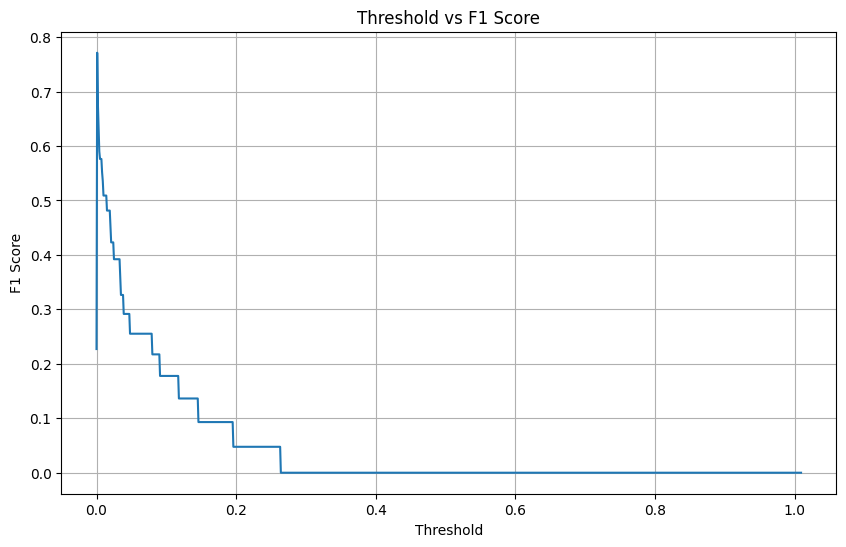

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    preds = []
    for i in pred_labels:
        if sum(i) > 4: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1 = f1_score(label, preds)
    f1_scores.append(f1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores
})

# Print the DataFrame
print(results_df)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['f1_score'])
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [30]:
results_df.to_csv('/home/ajeet/Sourav/threshold_vs_f1/longformer.csv')

In [76]:
delays = get_delays(pred_labels)
print(delays)

[10, 1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 5, 10, 10, 10, 10, 10, 10, 10, 2, 0, 0, 2, 0, 4, 10, 10, 10, 10, 4, 10, 8, 4, 3, 10, 10, 0, 0, 10, 5, 10, 10, 7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 2, 10, 10, 10, 10, 1, 10, 10, 2, 10, 0, 0, 1, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 6, 10, 10, 10, 10, 10, 6, 10, 10, 8, 0, 0, 5, 10, 9, 10, 10, 1, 7, 3, 10, 10, 2, 10, 10, 10, 0, 10, 0, 10, 0, 6, 3, 0, 3, 2, 10, 10, 10, 10, 10, 2, 7, 10, 1, 10, 3, 3, 10, 2, 10, 10, 10, 10, 1, 10, 0, 10, 10, 10, 10, 0, 10, 1, 10, 10, 0, 10, 10, 10, 10, 10, 0, 10, 3, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 7, 10, 10, 10, 10, 10, 10, 10, 10, 10, 4, 10, 10, 10, 10, 1, 10, 10, 10, 10, 7, 10, 1, 10, 10, 10, 10, 10, 10, 2, 10, 10, 10, 10, 10, 7, 10, 10, 10, 5, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 10, 0, 7, 10, 3, 10, 10, 10, 10, 10, 10, 1, 10, 10, 10, 10, 10,

In [77]:
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost
ERDE5 = calculate_ERDE(preds, delays, label, cfn, ctp, o)
ERDE50 = calculate_ERDE(preds, delays, label, cfn, ctp, o*10)
print(f"ERDE5 = {ERDE5*100}%\nERDE50 = {ERDE50*100}%")

ERDE5 = 4.656602084033431%
ERDE50 = 4.455078125%


## With Attention

In [31]:
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        self.attention = nn.MultiheadAttention(768, 12)
        self.fc1 = nn.Linear(in_features=768, out_features=384)
        self.fc2 = nn.Linear(in_features=384, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=32)
        self.fc4 = nn.Linear(in_features=32, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.unsqueeze(0)
        x, _ = self.attention(x, x, x)
        x = x.squeeze(0)
        x = torch.relu(self.fc2(torch.relu(self.fc1(x))))
        # Perform global pooling over the batch dimension
        x = torch.relu(self.fc3(x))
        x = torch.mean(x, dim=0, keepdim=True)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x

In [32]:
from tqdm import tqdm

model = BinaryClassifier()
# model.load_state_dict(torch.load("/media/souravsaini/Data/POP_OS/internship/models_wts/longformer/Aug_dataset/epoch_49_val_loss_0.1539282605572142.pt"))
model.load_state_dict(torch.load("/home/ajeet/Sourav/longformer/att/ckpt/model_best.pt"))

<All keys matched successfully>

In [33]:
probs, label, delay = evaluate(test_dataset, model)

100%|██████████| 320/320 [00:22<00:00, 13.94it/s]


In [34]:
probs

array([[0.00626798, 0.00503707, 0.0047513 , ..., 0.00742835, 0.0026765 ,
        0.00868425],
       [0.00993578, 0.00322613, 0.12610549, ..., 0.00473848, 0.01857298,
        0.12997708],
       [0.08043083, 0.00395711, 0.19276868, ..., 0.03748517, 0.09083208,
        0.00502199],
       ...,
       [0.01830302, 0.02830472, 0.02718624, ..., 0.01049639, 0.01448877,
        0.00316819],
       [0.01159891, 0.01066424, 0.00858018, ..., 0.0222023 , 0.02000696,
        0.020697  ],
       [0.07071353, 0.07029145, 0.16893788, ..., 0.79286212, 0.65820652,
        0.16038238]])

In [37]:
pred_labels = []
for i in range(0,len(probs)):
    temp = []
    for j in range(0, len(probs[i])):
        if probs[i][j]>0.3: temp.append(1)
        else: temp.append(0)
    pred_labels.append(temp)

In [38]:
preds = []
for i in pred_labels:
    if sum(i)>4: preds.append(1)
    else: preds.append(0)

precision = precision_score(label, preds)
recall = recall_score(label, preds)
print(f"precision = {precision}\nrecall = {recall}")

precision = 0.7674418604651163
recall = 0.8048780487804879


      threshold  f1_score
0         0.000  0.227147
1         0.001  0.229050
2         0.002  0.233618
3         0.003  0.245509
4         0.004  0.253870
...         ...       ...
1005      1.005  0.000000
1006      1.006  0.000000
1007      1.007  0.000000
1008      1.008  0.000000
1009      1.009  0.000000

[1010 rows x 2 columns]


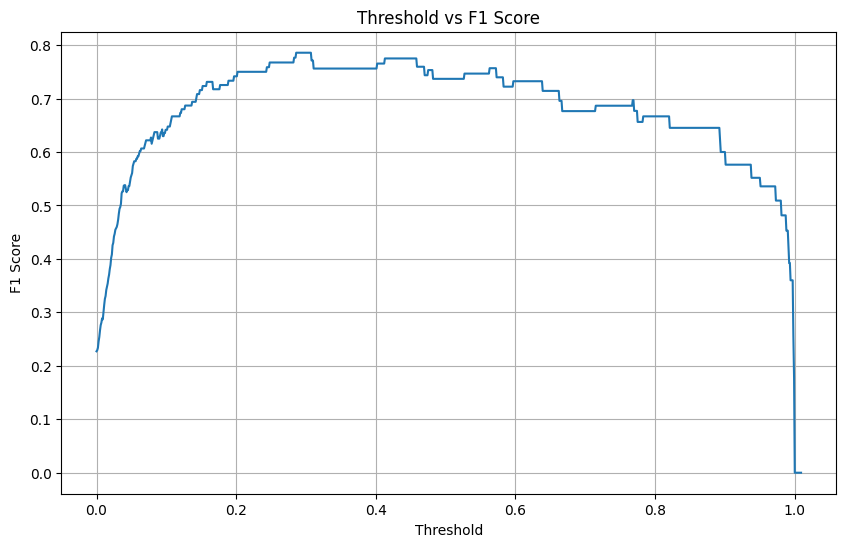

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Initialize lists to store results
thresholds = np.arange(0, 1.01, 0.001)
f1_scores = []

# Calculate F1 score for each threshold
for threshold in thresholds:
    pred_labels = []
    for i in range(len(probs)):
        temp = []
        for j in range(len(probs[i])):
            if probs[i][j] > threshold: 
                temp.append(1)
            else: 
                temp.append(0)
        pred_labels.append(temp)

    preds = []
    for i in pred_labels:
        if sum(i) > 4: 
            preds.append(1)
        else: 
            preds.append(0)
    
    f1 = f1_score(label, preds)
    f1_scores.append(f1)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'threshold': thresholds,
    'f1_score': f1_scores
})

# Print the DataFrame
print(results_df)

# Plot the curve
plt.figure(figsize=(10, 6))
plt.plot(results_df['threshold'], results_df['f1_score'])
plt.title('Threshold vs F1 Score')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()


In [36]:
results_df.to_csv('/home/ajeet/Sourav/threshold_vs_f1/longformerAttn.csv')

In [39]:
delays = get_delays(pred_labels, delay)

In [40]:
cfp = 0.01  # Cost of false positive
cfn = 1     # Cost of false negative
ctp = 1     # Cost of true positive
o = 5       # Parameter controlling the rate of increase for latency cost
ERDE5 = calculate_ERDE(preds, delays, label, cfn, ctp, o)
ERDE50 = calculate_ERDE(preds, delays, label, cfn, ctp, o*10)
print(f"ERDE5 = {ERDE5*100}%\nERDE50 = {ERDE50*100}%")

ERDE5 = 5.234860265160933%
ERDE50 = 4.113139711873017%
